In [1]:
import torch
import numpy as np

use_gpu = torch.cuda.is_available()
use_gpu

True

In [2]:
!ls ../input/journey-to-springfield/train/simpsons_dataset


abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [3]:
import pickle
import numpy as np
from skimage import io
from torch import nn
#from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
# загрузка изображений с классами по папкам
# batch_size = 64
data_transforms = {
    'min_classes': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-30,30)),
        transforms.RandomGrayscale(p=0.4),
        transforms.RandomVerticalFlip(p=0.5)        
    ]),
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}




In [5]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
  def __init__(self, datadir, min_class_transform, transform=None):
    tmp_dataset = datasets.ImageFolder(datadir)
    self.img_list = tmp_dataset.imgs
    self.min_class_transform = min_class_transform
    self.transform = transform
    self.class_names = tmp_dataset.classes
    self.n_classes = len(self.class_names)
    self.mean_percent_per_class = len(self.img_list)/self.n_classes/len(self.img_list)
    self.persent_per_class = [len([cl for _, cl in self.img_list if cl == c])/len(self.img_list) for c in range(self.n_classes)]
    self.weight_per_class = (1/np.array(self.persent_per_class)).tolist()

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, index):
      image = Image.open(self.img_list[index][0])
      if self.persent_per_class[self.img_list[index][1]] < self.mean_percent_per_class/10:
        image = self.min_class_transform(image)
      if self.transform:
        image = self.transform(image)
      return (image, self.img_list[index][1])


In [6]:
data_dir = '../input/journey-to-springfield/train/simpsons_dataset'
full_train_dataset = MyDataset(data_dir, data_transforms['min_classes'], data_transforms['train'])
# специальный класс для загрузки данных в виде батчей
#trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
#                                              shuffle=True, num_workers=2)
dataset_size = len(full_train_dataset)
class_names = full_train_dataset.class_names
n_classes = len(np.unique(full_train_dataset.class_names))
print(f'{dataset_size}, classes = {n_classes}')

20933, classes = 42


In [7]:
# classes_count = {c: len([cl for _, cl in full_train_dataset.img_list if cl == c]) for c in range(n_classes)}
# counters = sorted(list(classes_count.values()))
# classes_count

In [8]:
## функция создает массив весов по каждому объекту в зависимости от количества объектов этого класса
## чем меньше экземпляров класса, тем больше вес объекта
def make_weights(fullset, trainset, nclasses):                        
    # count = [0] * nclasses                                                      
    # for item in fullset.imgs:                                                         
    #     count[item[1]] += 1                                                     
    # weight_per_class = [0.] * nclasses                                      
    # N = float(sum(count))                                                   
    # for i in range(nclasses):                                                   
    #     weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(trainset.indices)                                              
    for idx, val in enumerate(trainset.indices):                                          
        weight[idx] = fullset.weight_per_class[fullset.img_list[val][1]]                                  
    return weight            

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

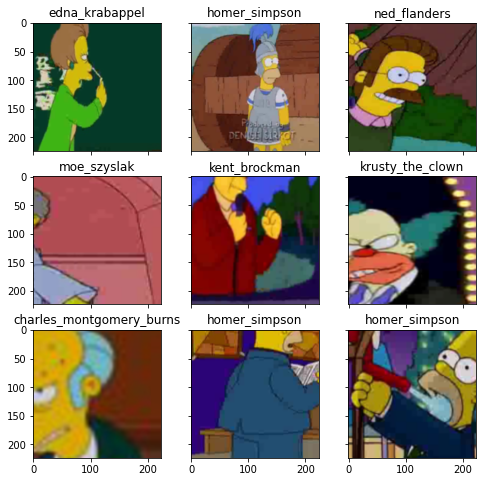

In [10]:
# выведем
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,20933))
    im_val, label = full_train_dataset[random_characters]
    imshow(im_val.data.cpu(), \
          title=class_names[label],plt_ax=fig_x)

In [11]:
# разбиение на тренировочный и валидационный
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
dataset_sizes = {'train': train_size, 'val': val_size}

In [12]:
batch_size = 64
weights = make_weights(full_train_dataset, train_dataset, n_classes)
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

In [13]:
#d_model = models.densenet169(pretrained=True)
d_model = torch.load('../input/saved-module/dense (1).pt')

In [14]:
## замораживаем начальные слои и размораживаем несколько последних
## меняем последние слои (классификационные) на нужные нам количество классов

# for param in d_model.parameters():
#     param.requires_grad = False
# in_f = d_model.classifier.in_features
# d_model.classifier = nn.Linear(in_features=in_f, out_features=n_classes, bias=True)
# for param in d_model.classifier.parameters():
#     param.requires_grad = True
for name,param in d_model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)


	 classifier.weight
	 classifier.bias


In [15]:
import time


def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [16]:
DEVICE = torch.device("cuda")
d_model = d_model.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
params_to_update = []
for name,param in d_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=5e-4, amsgrad=True)
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [17]:
_, losses = train_model(d_model, loss_fn, optimizer, num_epochs=8)

Epoch::   0%|          | 0/8 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

train iter::   0%|          | 0/262 [00:00<?, ?it/s]

val iter::   0%|          | 0/66 [00:00<?, ?it/s]

Training complete in 28m 21s
Best val Acc: 0.925961


In [18]:
import torch
torch.save(d_model, "dense.pt")

In [19]:
!ls -l ./

total 50064
---------- 1 root root      263 Aug 10 07:17 __notebook_source__.ipynb
-rw-r--r-- 1 root root 51257634 Aug 10 07:54 dense.pt


In [20]:
testdir = '../input/journey-to-springfield/testset/testset'
test_dataset = datasets.ImageFolder(data_dir, data_transforms['test'])
test_loader = DataLoader(test_dataset, shuffle=True)
def imshow_new(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_loader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow_new(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

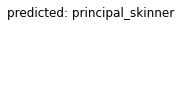

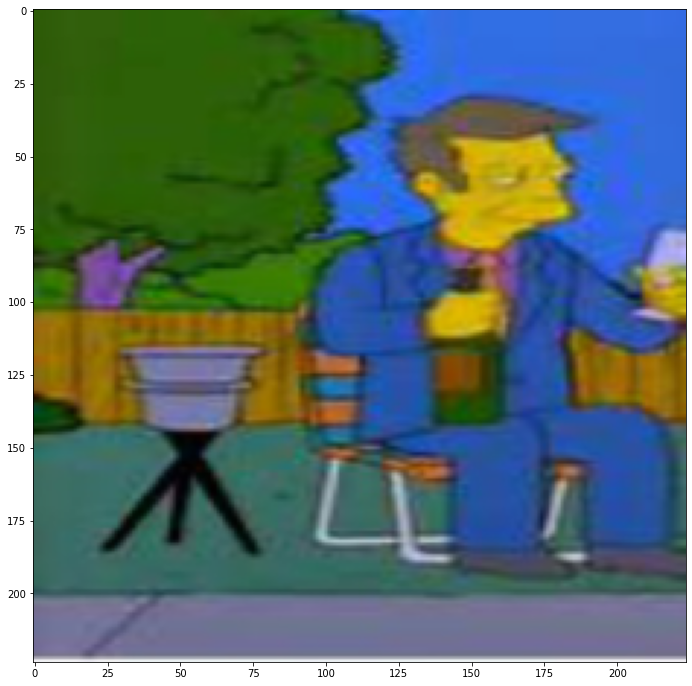

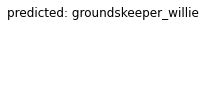

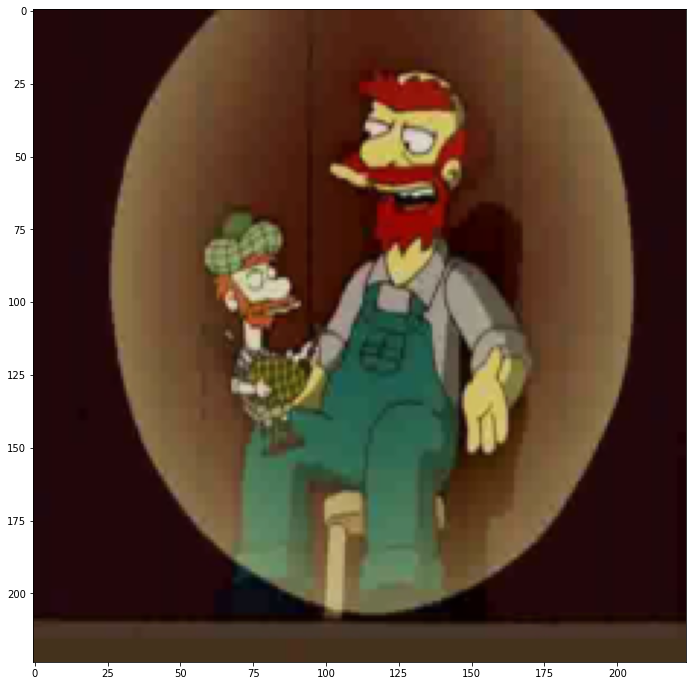

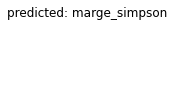

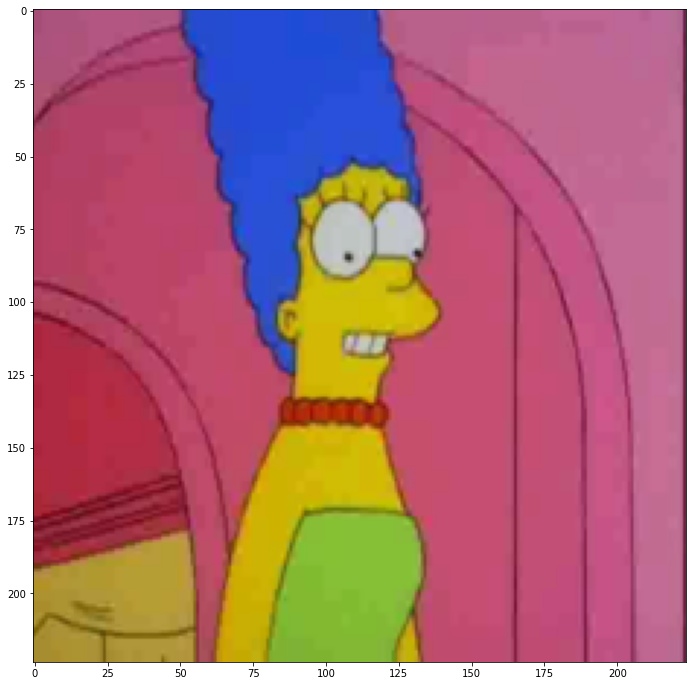

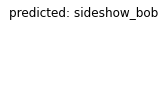

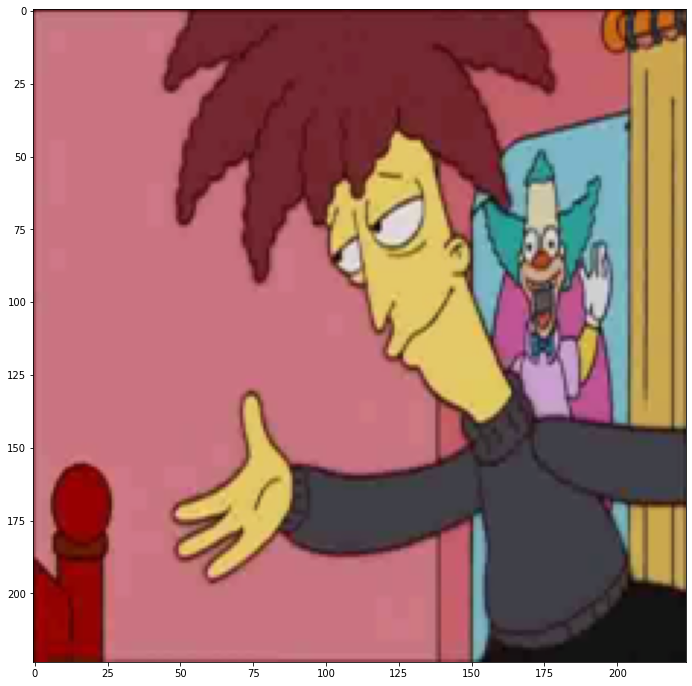

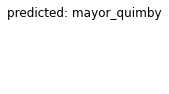

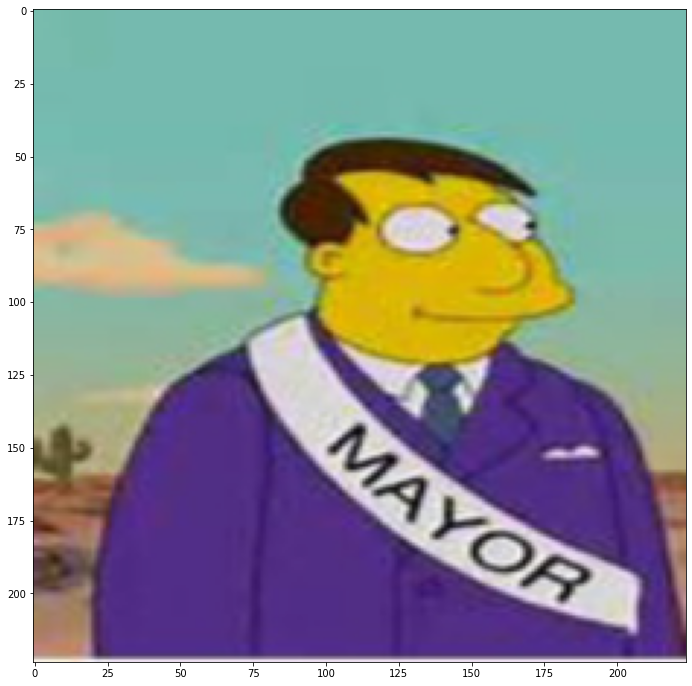

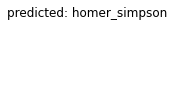

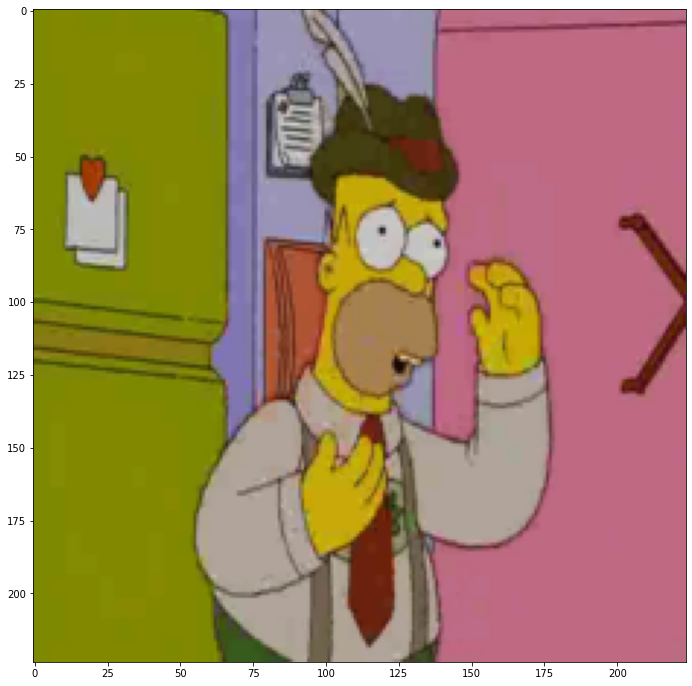

In [21]:
visualize_model(d_model)

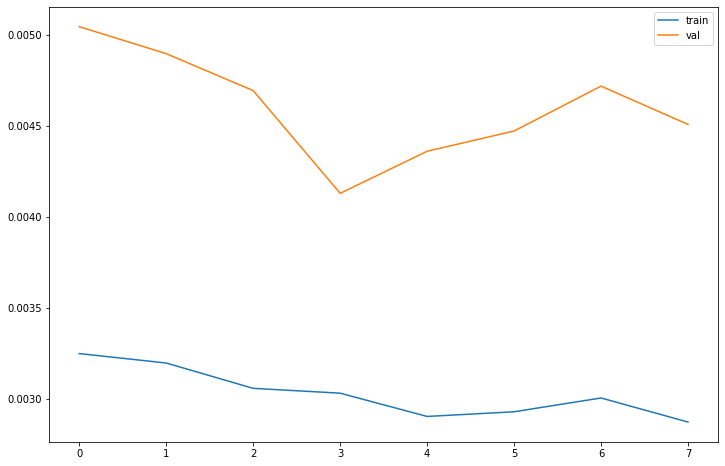

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [23]:
## make predictions on test
import pandas as pd
from PIL import Image
import helper
submissions = pd.DataFrame({'Id': [], 'Expected': []})
#i_model.to('cpu')
testdir = '../input/journey-to-springfield/testset/testset'
test_files = sorted(list(Path(testdir).rglob('*.jpg')))
d_model.eval()
out = None
for f in test_files:
  image = Image.open(f)
  image.load()
  inp = data_transforms['test'](image).unsqueeze(0).cuda()
  out = d_model(inp)
  submissions = submissions.append({'Expected': class_names[torch.max(out.data, 1)[1].item()], 'Id': f.name}, ignore_index=True)
#out.shape

submissions.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [24]:
submissions.to_csv('simpsons_contest_kaggle_dense.csv', index=False)